In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from pathlib import Path

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
base_path = Path("outputs/obs")

# Now in each folder for each npz file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory

save_path = base_path / "panel_adh.pdf"

controllers = ["cpg", "rule_based", "hybrid"]
terrain = ["flat", "blocks", "gapped", "mixed"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controllers]
n_conditions = len(conditions)

# sim_time = 1.0
# init_time = 0.0
timestep = 1e-4
all_rows = []
all_colors = np.tile(["r", "b"], n_conditions)


start_pts = 0
all_dir = True

for controller, terrain in conditions:
    for adh in adhesion:
        all_npz = list(base_path.glob(f"{controller}_{terrain}_*.npz"))
        assert (
            len(all_npz) > 1
        ), f"{controller=},{terrain=} does not contain any npz file"
        data_pts = []
        for npz_file in all_npz:
            obs_fly_list = np.load(npz_file)["fly"]
            # assert len(obs_list) == sim_time * 10_000
            if len(obs_fly_list) > start_pts:
                if all_dir:
                    distance = np.linalg.norm(
                        obs_fly_list[-1, 0, :2] - obs_fly_list[start_pts, 0, :2]
                    )
                else:
                    distance = obs_fly_list[-1, 0, 0] - obs_fly_list[start_pts, 0, 0]
                exp_len = (len(obs_fly_list) - start_pts) * timestep
            else:
                distance = 0.0
                exp_len = 100
            speed = distance / exp_len
            all_rows.append([controller.lower(), terrain.lower(), adh, speed, distance])

speed_df = pd.DataFrame(
    all_rows, columns=["controller", "terrain", "adhesion", "speed", "distance"]
)

In [4]:
print(
    speed_df[speed_df["terrain"] == "flat"]["speed"].min(),
    speed_df[speed_df["terrain"] == "flat"]["speed"].max(),
)

10.437405268351236 14.676584879557291


In [5]:
def plot(df):
    fig = plt.figure(figsize=(6, 2))

    widths = np.array([1, 0.2, 1, 0.2, 1, 0.2, 1])
    widths /= widths.sum()

    axs = {}

    terrains = ["flat", "gapped", "blocks", "mixed"]
    palette = ["tab:blue", "tab:orange", "tab:brown"]
    legend_labels = ["CPG-based", "Rule-based", "Hybrid"]

    for j, terrain in enumerate(["flat", "gapped", "blocks", "mixed"]):
        axs[terrain] = ax = fig.add_axes([widths[: j * 2].sum(), 0, widths[j * 2], 1])
        ax.set_title(terrain.capitalize() + " terrain")

        df = df if terrain == "flat" else df

        sns.boxplot(
            x="controller",
            y="speed",
            data=df.query(f"terrain == '{terrain}'"),
            width=0.6,
            ax=ax,
            showfliers=False,
            boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
            medianprops={"color": "gray", "linewidth": 0.5},
            whiskerprops={"color": "gray", "linewidth": 0.5},
            capprops={"color": "gray", "linewidth": 0.5},
        )
        sns.swarmplot(
            x="controller",
            y="speed",
            data=df.query(f"terrain == '{terrain}'"),
            hue="controller",
            size=1.75,
            palette=palette,
            ax=ax,
            legend=False,
        )

        ax.set_xmargin(0.1)

        for spine in ["top", "right", "bottom"]:
            ax.spines[spine].set_visible(False)

        if terrain == "flat":
            ax.set_ylabel("Avg. speed (mm/s)")
            ax.set_ylim(0, 15)
            ax.set_yticks(np.arange(0, 16, 5))
        else:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)

        if j > 1:
            ax.sharey(axs[terrains[j - 1]])

        ax.xaxis.set_visible(False)

    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=palette[i],
            markersize=5,
            label=legend_labels[i],
        )
        for i in range(3)
    ]

    ax = fig.add_axes([widths[:2].sum(), 0, widths[2:].sum(), 1])
    ax.axis("off")

    fig.legend(
        handles=handles,
        labels=legend_labels,
        loc="upper left",
        bbox_to_anchor=(1, 1),
        frameon=False,
        labelcolor=palette,
        handletextpad=0.6,
        handlelength=0,
        fontsize="large",
    )

    return axs

In [6]:
# remove nans
speed_df = speed_df.dropna()

p_values = {}
for terrain_type in ["flat", "gapped", "blocks", "mixed"]:
    hybrid_pts = speed_df[
        (speed_df["controller"] == "hybrid") & (speed_df["terrain"] == terrain_type)
    ]["speed"].values
    for controller in ["cpg", "rule_based"]:
        my_pts = speed_df[
            (speed_df["controller"] == controller)
            & (speed_df["terrain"] == terrain_type)
        ]["speed"].values
        u, p = mannwhitneyu(my_pts, hybrid_pts, alternative="less", method="asymptotic")
        # print(f"{variable} - {terrain_type} - {controller} vs hybrid: {p:.6f}")
        p_values[terrain_type, controller] = p

In [7]:
def get_asterisks(p):
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return "ns"

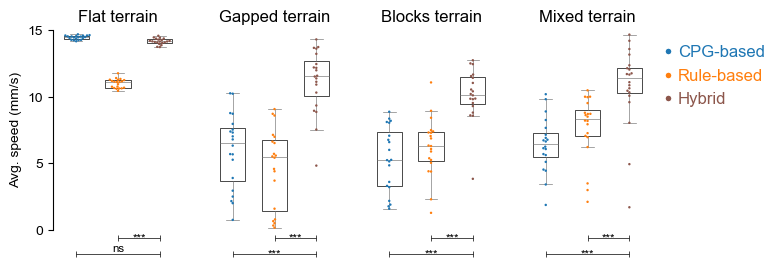

In [8]:
axs = plot(speed_df)
ax = axs["gapped"]
ax.set_ylim(0, None)

for terrain, ax in axs.items():
    for j, controller in enumerate(["cpg", "rule_based"]):
        p = p_values[terrain, controller]

        x = (j + 2) / 2
        y = (j * 0.8 - 1.2) / 10
        ax.errorbar(
            x,
            y,
            xerr=(2 - j) / 2,
            capsize=2,
            color="k",
            linewidth=0.5,
            capthick=0.5,
            transform=ax.get_xaxis_transform(),
            clip_on=False,
        )
        text = get_asterisks(p)
        ax.text(
            x,
            y,
            text,
            ha="center",
            va="bottom" if text == "ns" else "center",
            fontsize="small",
            transform=ax.get_xaxis_transform(),
            clip_on=False,
        )

Path("outputs").mkdir(exist_ok=True)
plt.savefig("outputs/speed_comparison.pdf", bbox_inches="tight", transparent=True)

In [9]:
terrains = ["flat", "gapped", "blocks", "mixed"]

rows = []

for terrain_type in terrains:
    hybrid_pts = speed_df[
        speed_df["controller"].eq("hybrid") & speed_df["terrain"].eq(terrain_type)
    ]["speed"].values
    rows.append([])

    for controller in ["cpg", "rule_based"]:
        my_pts = speed_df[
            (speed_df["controller"] == controller)
            & (speed_df["terrain"] == terrain_type)
        ]["speed"].values
        u, p = mannwhitneyu(my_pts, hybrid_pts, alternative="less", method="asymptotic")
        rows[-1].append(f"U = {int(u)}, p = {p:.1E}")

In [10]:
pd.DataFrame(rows, index=terrains, columns=["cpg < hybrid", "rule-based < hybrid"])

,cpg < hybrid,rule-based < hybrid
flat,"U = 346, p = 1.0E+00","U = 0, p = 3.4E-08"
gapped,"U = 25, p = 1.2E-06","U = 16, p = 3.5E-07"
blocks,"U = 16, p = 3.5E-07","U = 34, p = 3.8E-06"
mixed,"U = 43, p = 1.2E-05","U = 56, p = 5.2E-05"
